=== Lancement du Benchmark sur two_moons (Seeds: [42, 43]) ===
Génération des simulations...

 NORMALISATION : NONE

---> Seed 42 en cours...
  [Step     10] Loss: 1.4852 | Total Time: 3.0s
  [Step     25] Loss: 1.3923 | Total Time: 14.3s
  [Step     63] Loss: 1.0735 | Total Time: 22.9s
  [Step    158] Loss: 0.6642 | Total Time: 30.4s
  [Step    398] Loss: 0.4756 | Total Time: 39.7s
  [Step   1000] Loss: 0.4012 | Total Time: 54.9s

---> Seed 43 en cours...
  [Step     10] Loss: 1.4089 | Total Time: 2.1s
  [Step     25] Loss: 1.3104 | Total Time: 11.3s
  [Step     63] Loss: 1.0487 | Total Time: 18.8s
  [Step    158] Loss: 0.6452 | Total Time: 25.6s
  [Step    398] Loss: 0.4590 | Total Time: 40.4s
  [Step   1000] Loss: 0.3932 | Total Time: 53.9s

 NORMALISATION : LAYER

---> Seed 42 en cours...
  [Step     10] Loss: 1.3432 | Total Time: 3.7s
  [Step     25] Loss: 1.1265 | Total Time: 13.2s
  [Step     63] Loss: 0.9427 | Total Time: 20.2s
  [Step    158] Loss: 0.6946 | Total Time: 27.0s
 

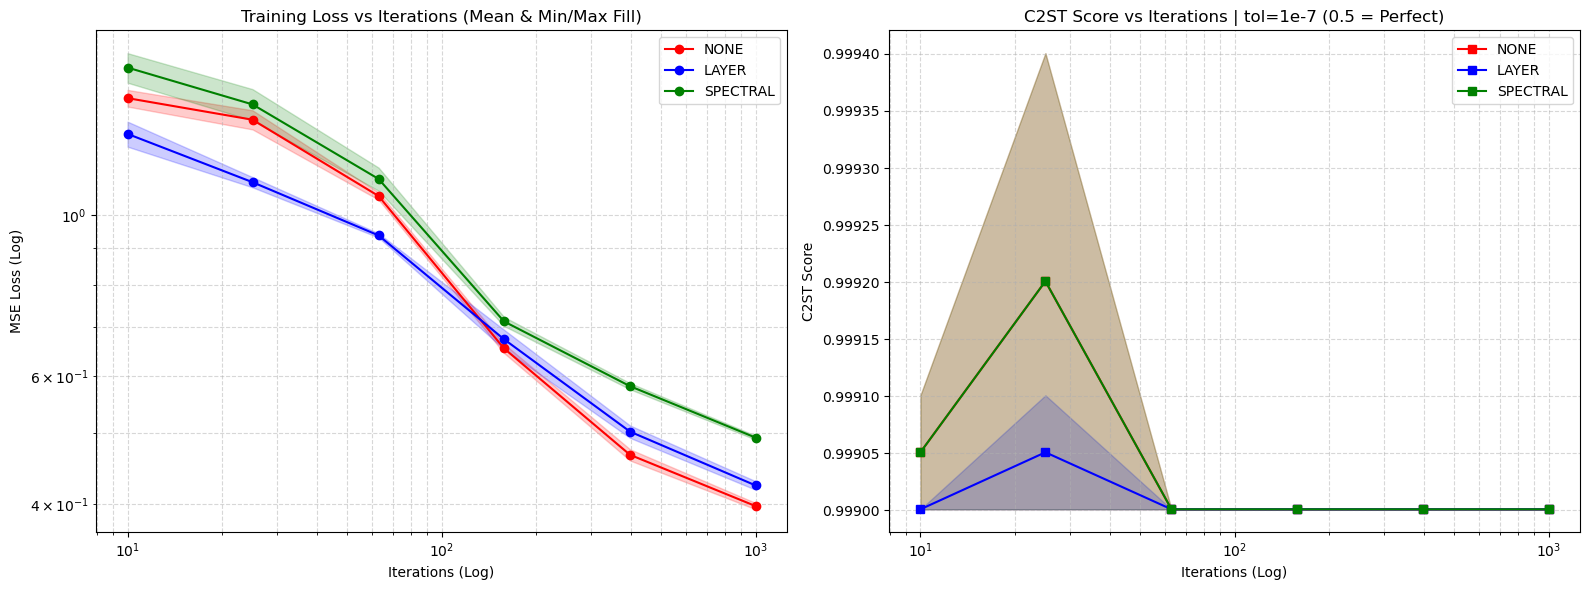

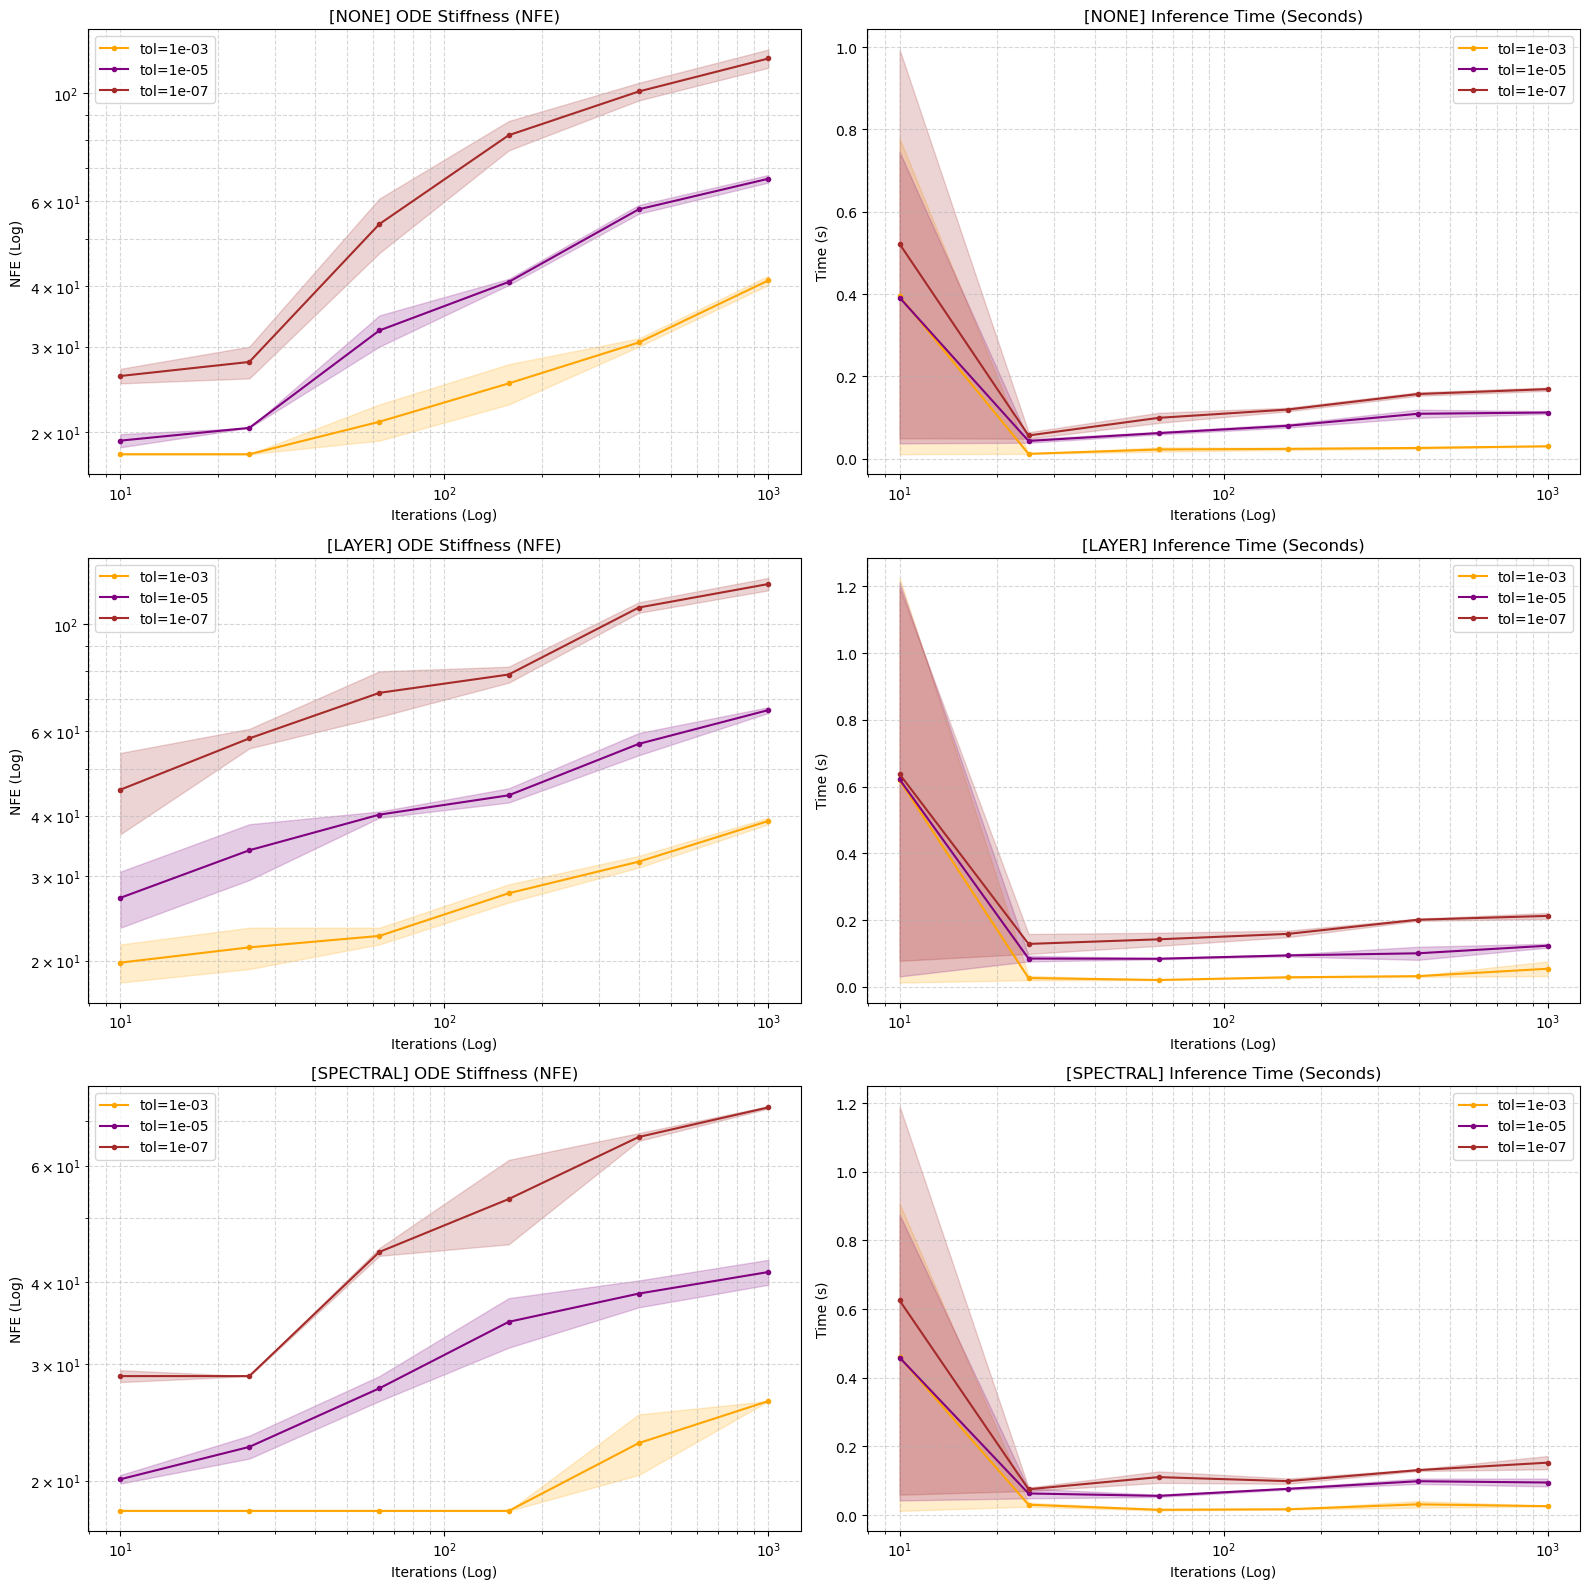

In [1]:
import time
import jax
import jax.numpy as jnp
import equinox as eqx
import diffrax
import optax
import numpy as np
import torch
import matplotlib.pyplot as plt
from typing import Literal
import sbibm
from sbibm.metrics import c2st
from collections import defaultdict
from flow_matching import *

# Assure-toi d'importer ta propre architecture ici
# from flow_matching import NormType, VectorFieldNetwork, train_step

def _to_jax(t: torch.Tensor) -> jax.Array:
    return jnp.array(t.numpy())

def _to_torch(x: jax.Array) -> torch.Tensor:
    return torch.from_numpy(np.array(x))

# ─────────────────────────────────────────────────────────────────────────────
# 1. Fonction d'Inférence modifiée (pour extraire les NFE)
# ─────────────────────────────────────────────────────────────────────────────
@eqx.filter_jit
def sample_posterior_with_stats(
    model, state, x_obs, key, num_samples, theta_dim, rtol, atol
):
    keys = jax.random.split(key, num_samples)
    
    def single_sample(k):
        theta_0 = jax.random.normal(k, shape=(theta_dim,))
        
        def vector_field_wrapper(t, y, args):
            v_t, _ = model(t, y, x_obs, state, inference=True)
            return v_t
        
        sol = diffrax.diffeqsolve(
            diffrax.ODETerm(vector_field_wrapper),
            diffrax.Dopri5(),
            t0=0.0, t1=1.0, dt0=0.01,
            y0=theta_0,
            stepsize_controller=diffrax.PIDController(rtol=rtol, atol=atol),
            max_steps=2000
        )
        # NFE moyen pour Dopri5 = num_steps * 6
        return sol.ys[-1], sol.stats["num_steps"] * 6

    samples, nfe_array = jax.vmap(single_sample)(keys)
    return samples, jnp.mean(nfe_array)


# ─────────────────────────────────────────────────────────────────────────────
# 2. Le Moteur de Benchmarking (Multiseed)
# ─────────────────────────────────────────────────────────────────────────────
def run_benchmark(
    task_name: str = "two_moons",
    num_simulations: int = 100_000,
    max_iterations: int = 100_000,
    num_eval_points: int = 6,
    eval_samples: int = 5_000,
    batch_size: int = 256,
    learning_rate: float = 3e-4,
    sigma_min: float = 1e-4,
    alpha: float = 0.0,
    seeds: list = [42, 43, 44]  # 3 Seeds par défaut
):
    print(f"=== Lancement du Benchmark sur {task_name} (Seeds: {seeds}) ===")
    task = sbibm.get_task(task_name)
    theta_dim = task.dim_parameters
    x_dim = task.dim_data
    reference = task.get_reference_posterior_samples(num_observation=1)
    x_obs = _to_jax(task.get_observation(num_observation=1)).squeeze(0)

    print("Génération des simulations...")
    prior = task.get_prior()
    simulator = task.get_simulator()
    thetas = prior(num_samples=num_simulations)
    xs = simulator(thetas)
    theta_jax, x_jax = _to_jax(thetas), _to_jax(xs)

    eval_steps = np.unique(np.logspace(1, np.log10(max_iterations), num=num_eval_points, dtype=int))
    
    norm_types = ["none", "layer", "spectral"]
    tolerances = [1e-3, 1e-5, 1e-7]
    
    # Dictionnaire imbriqué : results[norm][metric][seed] = [valeurs...]
    results = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
    
    for norm in norm_types:
        print(f"\n" + "="*50)
        print(f" NORMALISATION : {norm.upper()}")
        print("="*50)
        
        for seed in seeds:
            print(f"\n---> Seed {seed} en cours...")
            key = jax.random.PRNGKey(seed)
            key_model, key_train, key_sample = jax.random.split(key, 3)

            model, state = eqx.nn.make_with_state(VectorFieldNetwork)(
                theta_dim, x_dim, [32, 128, 512, 128, 32], depth_per_block=2, key=key_model, norm_type=norm
            )
            optim = optax.adam(learning_rate)
            opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))

            step_losses = []
            start_train_time = time.time()

            for step in range(1, max_iterations + 1):
                key_train, key_batch = jax.random.split(key_train)
                idx = jax.random.randint(key_batch, (batch_size,), 0, num_simulations)
                keys_b = jax.random.split(key_batch, batch_size)
                
                model, state, opt_state, loss = train_step(
                    model, state, opt_state,
                    theta_jax[idx], x_jax[idx], keys_b,
                    optim, sigma_min, alpha,
                )
                step_losses.append(float(loss))

                # --- ÉVALUATION AU PAS LOGARITHMIQUE ---
                if step in eval_steps:
                    avg_loss = np.mean(step_losses[-100:]) if len(step_losses) > 100 else np.mean(step_losses)
                    print(f"  [Step {step:6d}] Loss: {avg_loss:.4f} | Total Time: {time.time() - start_train_time:.1f}s")
                    
                    results[norm]["loss"][seed].append(avg_loss)

                    for tol in tolerances:
                        key_sample, subkey = jax.random.split(key_sample)
                        
                        inf_start = time.time()
                        samples_jax, nfe = sample_posterior_with_stats(
                            model, state, x_obs, subkey, eval_samples, theta_dim, rtol=tol, atol=tol
                        )
                        samples_jax.block_until_ready()
                        inf_time = time.time() - inf_start
                        
                        samples_torch = _to_torch(samples_jax)
                        c2st_val = float(c2st(reference, samples_torch))
                        
                        results[norm][f"c2st_{tol}"][seed].append(c2st_val)
                        results[norm][f"nfe_{tol}"][seed].append(float(nfe))
                        results[norm][f"inf_time_{tol}"][seed].append(inf_time)
                        
    return results, eval_steps

# ─────────────────────────────────────────────────────────────────────────────
# 3. Fonction de Visualisation (Agrégation Multiseed)
# ─────────────────────────────────────────────────────────────────────────────
def plot_benchmark_results(results, eval_steps):
    norm_colors = {"none": "red", "layer": "blue", "spectral": "green"}
    tol_colors = {1e-3: "orange", 1e-5: "purple", 1e-7: "brown"}
    
    # =========================================================================
    # FIGURE 1 : Training Loss et C2ST (tol=1e-7 uniquement)
    # =========================================================================
    fig1, axs1 = plt.subplots(1, 2, figsize=(16, 6))
    
    for norm in results.keys():
        # -- 1A. Training Loss --
        loss_matrix = np.array(list(results[norm]["loss"].values())) # Shape: (n_seeds, n_eval_points)
        loss_mean = loss_matrix.mean(axis=0)
        loss_min = loss_matrix.min(axis=0)
        loss_max = loss_matrix.max(axis=0)
        
        axs1[0].plot(eval_steps, loss_mean, color=norm_colors[norm], label=norm.upper(), marker='o')
        axs1[0].fill_between(eval_steps, loss_min, loss_max, color=norm_colors[norm], alpha=0.2)
        
        # -- 1B. C2ST (Uniquement tol = 1e-7) --
        c2st_matrix = np.array(list(results[norm]["c2st_1e-07"].values()))
        c2st_mean = c2st_matrix.mean(axis=0)
        c2st_min = c2st_matrix.min(axis=0)
        c2st_max = c2st_matrix.max(axis=0)
        
        axs1[1].plot(eval_steps, c2st_mean, color=norm_colors[norm], label=norm.upper(), marker='s')
        axs1[1].fill_between(eval_steps, c2st_min, c2st_max, color=norm_colors[norm], alpha=0.2)

    axs1[0].set_xscale('log')
    axs1[0].set_yscale('log')
    axs1[0].set_title("Training Loss vs Iterations (Mean & Min/Max Fill)")
    axs1[0].set_xlabel("Iterations (Log)")
    axs1[0].set_ylabel("MSE Loss (Log)")
    axs1[0].legend()
    axs1[0].grid(True, which="both", ls="--", alpha=0.5)

    axs1[1].set_xscale('log')
    axs1[1].set_title("C2ST Score vs Iterations | tol=1e-7 (0.5 = Perfect)")
    axs1[1].set_xlabel("Iterations (Log)")
    axs1[1].set_ylabel("C2ST Score")
    axs1[1].legend()
    axs1[1].grid(True, which="both", ls="--", alpha=0.5)

    plt.tight_layout()
    plt.show()

    # =========================================================================
    # FIGURE 2 : Grille 3x2 (NFE et Temps d'inférence)
    # =========================================================================
    fig2, axs2 = plt.subplots(3, 2, figsize=(16, 16))
    norm_types = ["none", "layer", "spectral"]
    tolerances = [1e-3, 1e-5, 1e-7]

    for i, norm in enumerate(norm_types):
        for tol in tolerances:
            # -- Colonne 1 : NFE --
            nfe_matrix = np.array(list(results[norm][f"nfe_{tol}"].values()))
            nfe_mean = nfe_matrix.mean(axis=0)
            nfe_min = nfe_matrix.min(axis=0)
            nfe_max = nfe_matrix.max(axis=0)
            
            axs2[i, 0].plot(eval_steps, nfe_mean, color=tol_colors[tol], label=f"tol={tol:.0e}", marker='.')
            axs2[i, 0].fill_between(eval_steps, nfe_min, nfe_max, color=tol_colors[tol], alpha=0.2)

            # -- Colonne 2 : Inference Time --
            inf_matrix = np.array(list(results[norm][f"inf_time_{tol}"].values()))
            inf_mean = inf_matrix.mean(axis=0)
            inf_min = inf_matrix.min(axis=0)
            inf_max = inf_matrix.max(axis=0)
            
            axs2[i, 1].plot(eval_steps, inf_mean, color=tol_colors[tol], label=f"tol={tol:.0e}", marker='.')
            axs2[i, 1].fill_between(eval_steps, inf_min, inf_max, color=tol_colors[tol], alpha=0.2)

        # Formattage NFE
        axs2[i, 0].set_xscale('log')
        axs2[i, 0].set_yscale('log')
        axs2[i, 0].set_title(f"[{norm.upper()}] ODE Stiffness (NFE)")
        axs2[i, 0].set_xlabel("Iterations (Log)")
        axs2[i, 0].set_ylabel("NFE (Log)")
        axs2[i, 0].legend()
        axs2[i, 0].grid(True, which="both", ls="--", alpha=0.5)

        # Formattage Inference Time
        axs2[i, 1].set_xscale('log')
        axs2[i, 1].set_title(f"[{norm.upper()}] Inference Time (Seconds)")
        axs2[i, 1].set_xlabel("Iterations (Log)")
        axs2[i, 1].set_ylabel("Time (s)")
        axs2[i, 1].legend()
        axs2[i, 1].grid(True, which="both", ls="--", alpha=0.5)

    plt.tight_layout()
    plt.show()

# ─────────────────────────────────────────────────────────────────────────────
# 4. Lancement
# ─────────────────────────────────────────────────────────────────────────────
# Attention: 3 normalisations * 3 seeds * 100k itérations = 9 entraînements complets !
# Prépare-toi à laisser tourner ton Mac un certain temps !
results, eval_steps = run_benchmark(
    max_iterations=1_000,
    num_eval_points=6,
    eval_samples=10,
    batch_size=256,
    seeds=[42, 43]  # Tu peux changer les seeds ici
)

plot_benchmark_results(results, eval_steps)